In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import time

import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")

import matplotlib.ticker as tck

from torchvision.utils import make_grid
from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform

import matplotlib 
# matplotlib.use('Qt5Agg')

import wandb # weights and biases for tracking of metrics

# make the plots inline again
%matplotlib inline

from code import *


from power_spherical import HypersphericalUniform, MarginalTDistribution, PowerSpherical

from mpl_toolkits.basemap import Basemap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

B = 1000

NC = 4
inverse = False

theta = torch.linspace(0,2*np.pi,B).to(device)

r = torch.ones(B).to(device)


theta = theta.unsqueeze(-1).repeat(1,NC)
r = r.unsqueeze(-1).repeat(1,NC)
r=r.unsqueeze(-2)
theta=theta.unsqueeze(-2)

# (NC,2)
w = torch.randn(NC,2).to(device)
# (B,NC,2)
w = w.unsqueeze(0).repeat(B,1,1)

# (B,d/2,NC,2) = (B, 1, NC, 2)
w = w.unsqueeze(-3)

w = r.unsqueeze(-1) * 0.99 * w / (1 + torch.norm(w, dim = -1, keepdim=True))

print('theta',theta.shape)
print('w',w.shape)
print('r',r.shape)

dj = jacobian_moebius(theta, w, r)
theta_out = f_moebius(theta, w, r, inverse=inverse)

print('dj',dj.shape)

theta torch.Size([1000, 1, 4])
w torch.Size([1000, 1, 4, 2])
r torch.Size([1000, 1, 4])
dj torch.Size([1000, 1, 4])


tensor(1.0003, device='cuda:0')


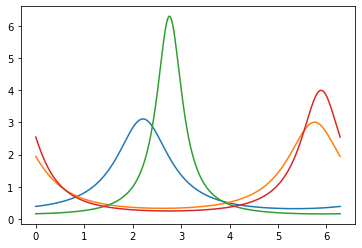

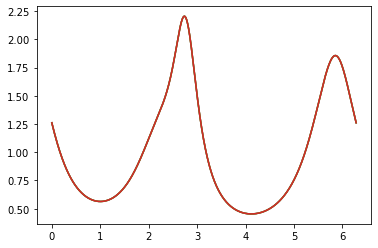

In [3]:
dj_avg = torch.mean(dj,dim=-1)
print(torch.mean(dj_avg))

theta=theta.squeeze()
dj = dj.squeeze()

plt.plot(theta.cpu().detach().numpy(),dj.cpu().detach().numpy())
plt.show()
plt.plot(theta.cpu().detach().numpy(),dj_avg.squeeze().cpu().detach().numpy())

### test conditional Moebius

In [6]:
inverse = True


num_centers = 12
flow_type = 'moebius'
num_bins = 18

dim_conditioner = 8

B = int(1e3)
theta = torch.linspace(0,2*np.pi,B).to(device)
# theta = torch.ones(B).to(device) *2*np.pi
r = torch.rand(B).to(device)


CSF = Circular_Spline_Flow(num_bins=16,
                           rezero_flag=False,
                           num_dim_conditioner=dim_conditioner)


moeb = Moebius_Flow(num_centers=num_centers, 
                    rezero_flag=False,
                    num_dim_conditioner = dim_conditioner,
                    num_hidden=HIDDEN_DIM_MOEBIUS_MLP)

moeb.to(device)
CSF.to(device)

d_halve = 1

x_condit = torch.randn(1,dim_conditioner).repeat(B,1).to(device)
theta = theta.unsqueeze(-1).repeat(1,d_halve)
r = r.unsqueeze(-1).repeat(1,d_halve)

print(theta.shape)
print(r.shape)
print(x_condit.shape)

# theta_out, ldj = moeb(theta,r, x_condit)
theta_out, ldj = CSF(theta,r, x_condit)

print('theta_out.shape',theta_out.shape)
print('ldj.shape',ldj.shape)
print()

torch.mean(torch.exp(ldj))

torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 8])
theta_out.shape torch.Size([1000, 1])
ldj.shape torch.Size([1000, 1])



tensor(1.0003, device='cuda:0', grad_fn=<MeanBackward0>)

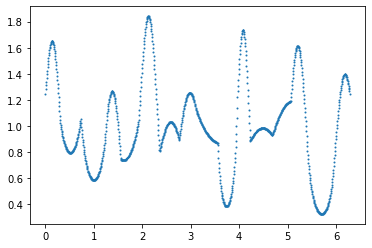

In [7]:
plt.scatter(theta.cpu().detach().numpy(),torch.exp(ldj).cpu().squeeze().detach().numpy(),s=1)
plt.show()

### test coupling moebius

In [9]:
inverse = True

B1 = 1000
B2 = 1
B3 = 1

D = 20

num_dim_data = D
num_centers = 6
flow_type = 'spline'
num_bins = 8

z = torch.randn(B1, B2, B3, D).to(device)
z = z / torch.norm(z, dim=-1,keepdim=True)

x_cond = torch.randn(B1, B2, B3, 512).to(device)


coup = Coupling(num_dim_data=num_dim_data, 
                flow_type=flow_type,
                num_centers=num_centers, 
                num_bins= num_bins,
                rezero_flag=False,
                num_dim_conditioner=512,
                learnable_convex_weights=False,
                cap_householder_refl=False)

coup.to(device)

sldj = 0 
out, ldj, _ = coup(z,sldj,x_cond)
ldj = torch.exp(ldj)
print('after forward pass',ldj.shape)
print(out.shape)
# print(torch.norm(out,dim=-1))

print(torch.mean(ldj))

after forward pass torch.Size([1000, 1, 1])
torch.Size([1000, 1, 1, 20])
tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)


### Test Neural Spline Flow

In [ ]:
    

class Neural_Spline_Flow(torch.nn.Module):
    
    """
    Neural Spline Flow implementation to fit a given distribution on the unit interval [0,1].
    
    Conditionally transforms a set (z1, z2, .. zD) where each z_i lives in [-1, 1] in an autoregressive manner.

    For each transformer f_{psi_i}(z_i) the function predicts a parameter set consisting of widths, heights and derivatives denoted by
    psi_i = g(z_<i). This means psi_i depends on all z_j up to (excluding) z_i. 

    Furthermore, it is possible to condition this transformation on an additional set 
    x_conditioner, that is psi_i = g(z_<i | x_conditioner) and out_i = f_i(z_i | x_conditioner). 

    This transformation is realized for a batch of data points.  
    """
    
    def __init__(self, 
                 num_bins, 
                 num_dim,
                 num_dim_conditioner=None, 
                 num_hidden=HIDDEN_DIM_SPLINE_MLP, 
                 circular=False, 
                 left=-1, 
                 right=1):


        super().__init__()
        
        self.circular = circular
        self.num_bins = num_bins
        self.num_dim = num_dim
        
        # check documentation of circular RQ_NSF func
        # TODO: in overleaf richtig festhalten warum num_bins einer weniger wenn circular

        # if circular have 3K parameters because actually K + 1 derivatives but s_0 = s_K
        # if non circular have 3K + 1 paramters because have K + 1 derivatives
        
        if circular:
            self.num_bins_deriv = anum_bins
            self.left, self.right = 0, 2 * np.pi
        else:
            self.num_bins_deriv = num_bins + 1
            self.left, self.right = left, right        
        
        # TODO: initialize bias weights with ones for derivative part
        # TODO: make this prettier
        self.params_predictor = MLP_masked(num_inputs=self.num_dim, 
                                           num_hidden=num_hidden, 
                                           num_outputs_widhts_heights=self.num_bins * num_dim,
                                           num_outputs_derivatives=self.num_bins_deriv * num_dim,
                                           num_dim_conditioner=num_dim_conditioner)
                                          
    def forward(self, 
                x, 
                x_conditioner=None,
                r=None, 
                inverse=False):
        
        # NOTE: added r as argument so that Neural Spline Flow and Moebius have the same arguments.

        """
        Autoregressive transformation of [-1,1]^D. Note that we do this in reversed order. 
        
        Args:
            x (batch, D)
            x_conditioner (batch, num_dim_conditioner) where N is arbitray conditioner dimension
        Returns
            output (batch, D)
            log_dj (batch, D)

        -----------
        
        Args:
            theta:         (B1, B2,.., BN, d/2)
            x_conditioner: (B1, B2,.., BN, N)
            r:             (B1, B2,.., BN)
            
        Return:
            theta_out:   (B1, B2,.., BN, d/2)
            ldj:         (B1, B2,.., BN, d/2)
        

        """
        
        batch_size = x.shape[0]
                
        # TODO make this prettier
        num_inputs = self.num_dim
        
        if not inverse:  
            
            # params are of shape (batch, D, K) or (batch, D, K+1) for derivative, 
            # where D is dimension of the data and K is the number of bins
            
            width, height, deriv = self.params_predictor(x=x, x_conditioner=x_conditioner)

            # NOTE: this way of reshaping is veeery! important for retaining the autoregressive structure of the masked MLP
            width = width.view(-1, self.num_bins, num_inputs).permute(0,2,1)
            height = height.view(-1, self.num_bins, num_inputs).permute(0,2,1)
            deriv = deriv.view(-1, self.num_bins_deriv, num_inputs).permute(0,2,1)

            if self.circular:
                # circular spline (derivatives at the boundaries are equal)
                outputs, logabsdet = circular_RQ_NSF(
                    inputs = x,
                    unnormalized_widths = width,
                    unnormalized_heights = height,
                    unnormalized_derivatives = deriv,
                    left = self.left,
                    right = self.right)

            else: 
                outputs, logabsdet = rational_quadratic_spline(
                    inputs = x,
                    left= self.left,
                    right = self.right,
                    bottom = self.left,
                    top = self.right,
                    unnormalized_widths = width,
                    unnormalized_heights = height,
                    unnormalized_derivatives = deriv)
        else:
            """
            Follow inversion of masked autoregressive flows of Papamakarios 2019 https://arxiv.org/pdf/1912.02762.pdf section 3.1.2

            """
            logabsdet = torch.tensor([]).to(device)

            z_random = torch.rand(batch_size, num_inputs).to(device) * (self.right - self.left) + self.left

            for idx in range(num_inputs):
                
                width, height, deriv = self.params_predictor(z_random, x_conditioner = x_conditioner)

                # (B, D, K)
                width = width.view(-1, self.num_bins, num_inputs).permute(0,2,1)
                height = height.view(-1, self.num_bins, num_inputs).permute(0,2,1)
                deriv = deriv.view(-1, self.num_bins_deriv, num_inputs).permute(0,2,1)
                
                
                
                if self.circular:
                    outputs_0, logabsdet_0 = circular_RQ_NSF(
                        inputs = x,
                        unnormalized_widths = width,
                        unnormalized_heights = height,
                        unnormalized_derivatives = deriv,
                        left = self.left,
                        right = self.right,
                        inverse = True)

                else:
                    outputs_0, logabsdet_0 = rational_quadratic_spline(
                        inputs = x,
                        left= self.left,
                        right = self.right,
                        bottom = self.left,
                        top = self.right,
                        unnormalized_widths = width,
                        unnormalized_heights = height,
                        unnormalized_derivatives = deriv,
                        inverse = True)

                z_random[:, idx] = outputs_0[:, idx]

                logabsdet = torch.cat([logabsdet, logabsdet_0[:, idx].view(-1,1)], dim=1)
                
            outputs = z_random 

        return outputs, logabsdet

    
    # TODO: rename to get_conditioner
    
    def get_unnormalized_params(self, x, x_conditioner=None):
        """
        Args: 
            x (batch, D)
        Returns:
            params (batch, D, 3 * num_bins + 1) or (batch, D, 3 * num_bins) for interval or circle transformation
        """

        return self.params_predictor(x, x_conditioner)



 
 

    